In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True

import statsmodels.stats.weightstats as wsts

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [2]:
df = pd.read_csv('data/credit_card_default_analysis.csv')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.where(df.MARRIAGE.isin([1,2])).groupby('EDUCATION')['MARRIAGE'].value_counts()

EDUCATION  MARRIAGE
0.0        2.0           10
           1.0            4
1.0        2.0         6809
           1.0         3722
2.0        2.0         7020
           1.0         6842
3.0        1.0         2861
           2.0         1909
4.0        2.0           68
           1.0           52
5.0        1.0          150
           2.0          127
6.0        1.0           28
           2.0           21
Name: MARRIAGE, dtype: int64

In [7]:
import statsmodels.stats.proportion as psts

In [9]:
psts.proportions_ztest(10,14, 0.5, prop_var=0.5)

(1.6035674514745464, 0.10880943004054568)

/Users/artem/miniconda3/envs/mldaspec/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


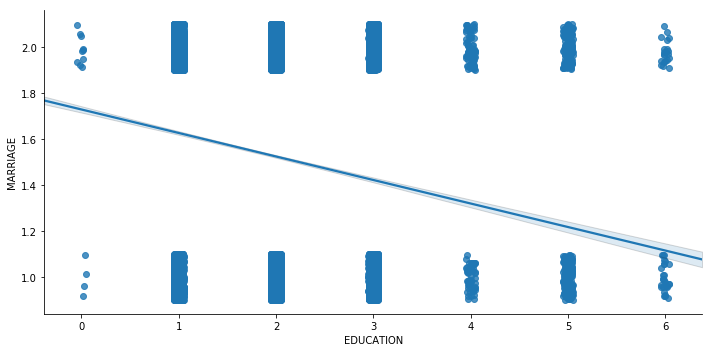

In [6]:
sns.lmplot(data=df.where(df.MARRIAGE.isin([1, 2])), x='EDUCATION', y='MARRIAGE',
           aspect=2, x_jitter=0.05, y_jitter=0.1);

## Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
- a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

#### Визуальная и точечная оценка

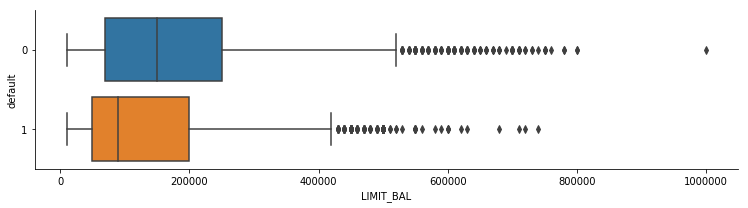

In [16]:
sns.catplot(data=df, x='LIMIT_BAL', y='default',
            kind='box', height=3, aspect=3.5,
            orient='h');

In [39]:
default0 = df[df.default == 0]
default1 = df[df.default == 1]

In [4]:
default0_lim = default0['LIMIT_BAL']
default1_lim = default1['LIMIT_BAL']

Оценим точечено. Видим, что в среднем кредитный лимит, у тех кто отдал кредит, был выше на 60к чем у тех, кто не отдал.

In [5]:
print('Median limit balance difference',
      np.median(default0_lim) - np.median(default1_lim))

Median limit balance difference 60000.0


Чтобы построить интервальную оценку среднего, взглянем на распределения признака. Из гистограм видно, что распределение похоже на Пуассоновское, однако мы не уверены в этом, поэтому воспользуемся бустрапированной выборкой для интервальной оценки разности медиан выборок. Бустрап, благодаря своей универсальности позволяет делать оценки на неизвестных нам распределениях.

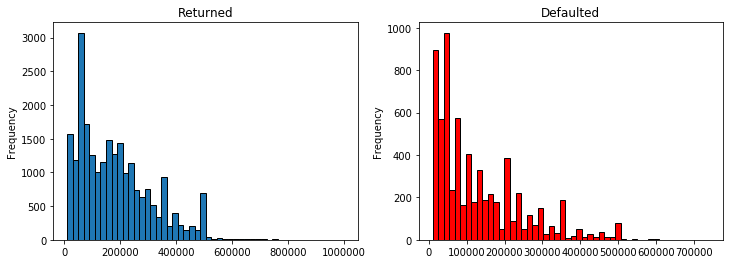

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(121)
df[df.default==0].LIMIT_BAL.plot(kind='hist', bins=50);
plt.title('Returned')
plt.subplot(122)
df[df.default==1].LIMIT_BAL.plot(kind='hist', bins=50, color='r');
plt.title('Defaulted');

In [7]:
def get_bootstrap_samples(data, n_samples):
    ints = np.random.randint(0, len(data), size=(n_samples, len(data)))
    return np.asarray(data)[ints]

In [8]:
def tolerance_int(stat, alpha):
    return np.percentile(stat, [100*alpha/2, 100*(1-alpha/2)])

In [9]:
default0_lim_boot = get_bootstrap_samples(default0_lim, 10000)
default1_lim_boot = get_bootstrap_samples(default1_lim, 10000)

In [10]:
default0_lim_med_scores = np.apply_along_axis(np.median, 1, default0_lim_boot)
default1_lim_med_scores = np.apply_along_axis(np.median, 1, default1_lim_boot)

In [11]:
def0_def1_lim_med_diffs = default0_lim_med_scores - default1_lim_med_scores

Как видно из интервальной оценки, в среднем у тех, кто отдаёт кредит кредитный лимит на 60000-70000 тысяч больше

In [12]:
tolerance_int(def0_def1_lim_med_diffs, 0.05)

array([60000., 70000.])

Проверим гипотезу о равенстве распределений с помощью непараметрического критерия знаковых рангов Уилкоксона-Манна-Уитни

In [13]:
 sc.stats.mannwhitneyu(default0_lim, default1_lim, alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Перестановочный критерий для несвязанных выборок. Я собрал пеерстановочные функции от авторов курса в один файл. Чтобы всё работало, поместите файл в одну папку с ноутбуком.
https://github.com/armavox/mldaspec/blob/master/course4/notebooks/permutation_criteria.py

In [14]:
import permutation_criteria as perm

perm.permutation_test_2sample_ind(default0_lim, default1_lim, max_permutations=1000)

### Вывод по заданию 1:  
Распределения признака 'LIMIT_BAL' для подвыборок из вернувших (default = 0) и не вернувших (default = 1) кредит отличны друг от друга. Это показывают интервальная оценка медиан на бустрапированных подвыборках, критерий Манна-Уитни, а также перестановочный критерий для двух независимых выборок. 

Из этого можно сделать следующие выводы:
- Люди, у которых выше кредитный лимит более склонны возвращать кредит чем  те, у которых кредитный лимит ниже.
- Скорее всего, некоторый алгоритм назначения кредитного лимита, который был применен для установления значений в этой выборке работает успешно.
- Возможно, выборка смещена. То есть кредитный лимит назначен по каким-то предыдущим сведениям о кредитной истории клиентов, и тем, кто уже успешно возвращал кредит назначен больший кредитный лимит. Если признак 'LIMIT_BAL' в выборке составлен с использованием истории возврата кредитов клиентами, то анализировать её так как это сделано выше будет некорректно.

## Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

Доли вернувших кредит мужчин и женщин:

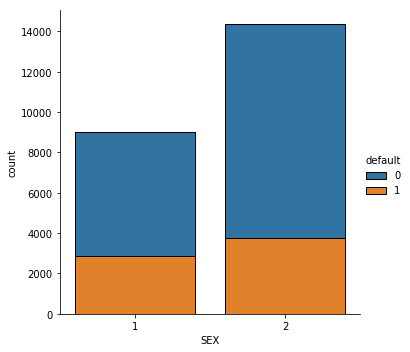

In [71]:
sns.catplot(data=df, x='SEX', hue='default', kind='count', dodge=False);

In [55]:
def_male_sample = df[df.SEX == 1]['default']
def_female_sample = df[df.SEX == 2]['default']

In [44]:
import statsmodels.stats.proportion as psts

Посмотрим на доверительные интервалы для доли невернувших кредиты мужчин и женщин

In [65]:
male_confint = psts.proportion_confint(def_male_sample.sum(), len(def_male_sample))
female_confint = psts.proportion_confint(def_female_sample.sum(), len(def_female_sample))
print('Мы можем с уверенностью в 95% говорить, что кредит не вернут:\n'
      f'от {male_confint[0]*100:.4f}% до {male_confint[1]*100:.4f}% мужчин\n'
      f'и от {female_confint[0]*100:.4f}% до {female_confint[1]*100:.4f}% женщин')

Мы можем с уверенностью в 95% говорить, что кредит не вернут:
от 23.3977% до 24.9368% мужчин
и от 20.1854% до 21.3671% женщин


Проверим с помощью z-критерия для доли для двух независимых выборок:

In [74]:
res = psts.proportions_ztest(
    [default_male_sample.sum(), default_female_sample.sum()],
    [len(default_male_sample), len(default_female_sample)])
print(f'Z-stat: {res[0]:.4f}, p-value: {res[1]}')

Z-stat: 6.9214, p-value: 4.472804335814144e-12


Достигаемый уровень значимости очень мал. Можно с уверенностью отвергнуть нулевую гипотезу о равенстве долей мужчин и женщин, не вернувших кредит.

## Задание 3  
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

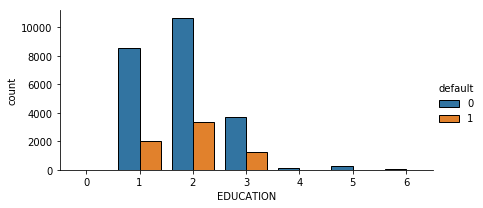

In [35]:
sns.catplot(data=df, x='EDUCATION', hue='default', kind='count', aspect=2, height=3);

In [51]:
df.groupby(['EDUCATION','default'])['default'].agg(['count', 'mean', 'std'])

count  mean  std
EDUCATION default                  
0         0           14     0  0.0
1         0         8549     0  0.0
          1         2036     1  0.0
2         0        10700     0  0.0
          1         3330     1  0.0
3         0         3680     0  0.0
          1         1237     1  0.0
4         0          116     0  0.0
          1            7     1  0.0
5         0          262     0  0.0
          1           18     1  0.0
6         0           43     0  0.0
          1            8     1  0.0

In [ ]:
sc.stats.chi2_contingency()

In [17]:
df[['EDUCATION', 'default']].corr()

,EDUCATION,default
EDUCATION,1.000000,0.028006
default,0.028006,1.000000


In [50]:
sc.stats.pearsonr(df['EDUCATION'], df['default'])

(0.02800607765624997, 1.225038033334144e-06)

In [ ]:
obs = 

In [ ]:
binned = sc.stats.